In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from numpy.fft import fft, ifft
from IPython.display import Audio

In [2]:
FRAME_SIZE = 2048
SKIP = 1024

In [3]:
# testing file can be either test_audio.wav or helicopter.wav
Fs, data = read('Croed-ky1.wav')
numFrames = int(len(data) / SKIP)
output = np.zeros(len(data))
window_num = 0
noise_spectrum = np.zeros(FRAME_SIZE)
frame = np.zeros(FRAME_SIZE)

residual = np.zeros(FRAME_SIZE)

previous = np.zeros(FRAME_SIZE)
current = np.zeros(FRAME_SIZE)
future = np.zeros(FRAME_SIZE)

c_flag = 0

FileNotFoundError: [Errno 2] No such file or directory: 'Croed-ky1.wav'

In [4]:
for i in range(numFrames):
    frame = data[i * SKIP : (i * SKIP + FRAME_SIZE)]
    
    if(len(frame) < FRAME_SIZE):
        continue
        
    #Judging non-speech and speech activity
    energy = np.zeros(frame.shape[0])
    for j in range(frame.shape[0]):
        energy[j] = pow(frame[j], 2)
        
    if (sum(energy) < 990000000):
        f_flag = 0
    else:
        f_flag = 1
    
    if (f_flag == 0):  #if non-speech get noise spectrum
        curFft = np.abs(np.fft.fft(frame))  #get N
        
        #calculate residual noise
        for p in range(FRAME_SIZE):
            absolute = np.abs(curFft[p] - noise_spectrum[p]*curFft[p]/np.abs(curFft[p]))
            if (absolute > residual[p]):
                residual[p] = absolute
                
        #calculate noise_spectrum
        noise_spectrum = (noise_spectrum * window_num + curFft)/(window_num + 1)
        window_num = window_num + 1
        
    #start from third future frame, use to update first and second frame
    if (i<2):
        continue
    
    windowed = np.zeros(FRAME_SIZE)
    temp_ns = np.zeros(FRAME_SIZE)
    for k in range(FRAME_SIZE):
        #compute future data
        windowed[k] = frame[k] * (0.5 - 0.5*np.cos(2*np.pi*k/(FRAME_SIZE-1)))
        #compute current data
        temp_ns[k] = data[(i-1) * SKIP +k]* (0.5 - 0.5*np.cos(2*np.pi*k/(FRAME_SIZE-1)))
    
    #future fft
    curFft = np.fft.fft(windowed)
    magnitude = np.abs(curFft)
    
    #current fft
    curFft_ns = np.fft.fft(temp_ns)
    
    # spectral subtraction estimator + halfway rectifier
    for t in range(FRAME_SIZE):
        if (magnitude[t] < noise_spectrum[t]):
            future[t] = 0
        else:
            future[t] = (magnitude[t] - noise_spectrum[t])*curFft[t]/magnitude[t]
            
            
    if(c_flag==0):  #handle data for current frame if non-speech
        current= 0.0001*curFft_ns
        
    else:    #handle data for current frame if speech
        for t in range(FRAME_SIZE):
            if (np.abs(current[t]) < residual[t]):
                ada = [np.abs(previous[t]), np.abs(current[t]), np.abs(future[t])]
                min_value = np.min(ada)
                if (min_value == 0):
                    current[t] = 0
                else:
                    current[t] = 2*min_value*current[t]/ada[1]
                
       
            
    temp = np.fft.ifft(previous)
    output[(i-2) * SKIP : (i-2) * SKIP + FRAME_SIZE] = output[(i-2) * SKIP : (i-2) * SKIP + FRAME_SIZE] + temp
    
    previous = current
    current = future
    c_flag = f_flag

NameError: name 'numFrames' is not defined

In [28]:
# Play out the original audio
Audio(data, rate=Fs)

In [29]:
# Play out the output audio
Audio(output, rate=Fs)

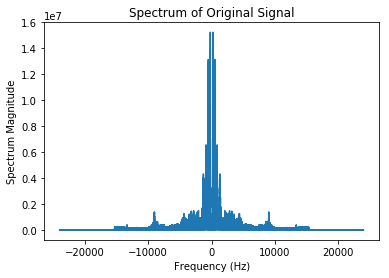

In [30]:
DFT = np.fft.fft(data)

#Generate the frequency values in horizontal axis
freq = np.fft.fftfreq(data.size, 1/Fs)
plt.plot(freq,abs(DFT))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectrum Magnitude')
plt.title('Spectrum of Original Signal')
plt.show()

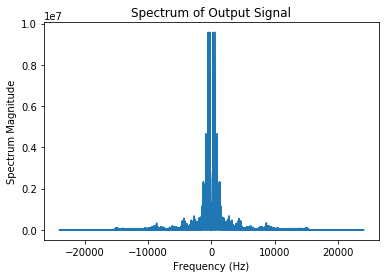

In [31]:
DFT = np.fft.fft(output)
#Generate the frequency values in horizontal axis
freq = np.fft.fftfreq(output.size, 1/Fs)
plt.plot(freq,abs(DFT))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectrum Magnitude')
plt.title('Spectrum of Output Signal')
plt.show()

In [32]:
# Print out sampling frequency
print(Fs)

48000
